<div style="border-radius:10px; padding: 15px; background-color: #CDE8E5; font-size:120%; text-align:left; color: #fffff">

<h2 align="left"><font color=#4D869C>Problem:</font></h2>
Given a dataset of chest X-ray images labeled as "normal" or "opacity," the objective is to develop a binary classification model to distinguish between these categories. The model will be implemented using PyTorch and deployed with TorchServe for scalable, real-time inference.

<div style="border-radius:10px; padding: 15px; background-color: #CDE8E5; font-size:120%; text-align:left">

<h2 align="left"><font color=#4D869C>Objectives:</font></h2>

### 1. **Preprocessing and Data Augmentation:**

Images are resized, normalized, and contrast-enhanced. Augmentation techniques like rotations, flips, and brightness adjustments increase variability to improve generalization.

### 2. **Classification:**

A custom CNN model is built with convolutional, pooling, and fully connected layers tailored to extract features and classify images into "normal" or "opacity" categories, using sigmoid for probabilities.

### 3. **Model Training and Evaluation:**

The model is trained using binary cross-entropy loss and Adam optimizer.



<a id="contents_tabel"></a>    
<div style="border-radius:10px; padding: 15px; background-color: #CDE8E5; font-size:130%; text-align:left">

<h2 align="left"><font color=#4D869C>Table of Contents:</font></h2>
    
* [Step 1 | Setup and Initialization](#initial_analysis)  
* [Step 2 | Preprocessing](#data_cleaning)
* [Step 3 | Classification Model and Evaluation](#preprocessing)
* [Step 4 | Save Model & Conclusions](#conclusions)

<a id="#initial_analysis"></a>
# <p style="background-color: #4D869C; font-family:calibri; color:white; font-size:135%; font-family:Verdana; text-align:center; border-radius:15px 50px; padding: 15px;">Step 1 | Setup and Initialization</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

In [2]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(143421)
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


<a id="#data_cleaning"></a>
# <p style="background-color: #4D869C; font-family:calibri; color:white; font-size:135%; font-family:Verdana; text-align:center; border-radius:15px 50px; padding: 15px;">Step 2 | Preprocessing</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [3]:
# Define the transformations for the training and testing data
train_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=0, shear=0.1),  # Shear transformation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Rescale the pixel values
])

test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Rescale the pixel values
])


In [4]:
# Load the datasets
train_data = datasets.ImageFolder('data', transform=train_transform)
test_data = datasets.ImageFolder('test_data', transform=test_transform)

In [5]:
# Create data loaders
train_loader = DataLoader(train_data, **train_kwargs, shuffle=True)
test_loader = DataLoader(test_data, **test_kwargs, shuffle=False)

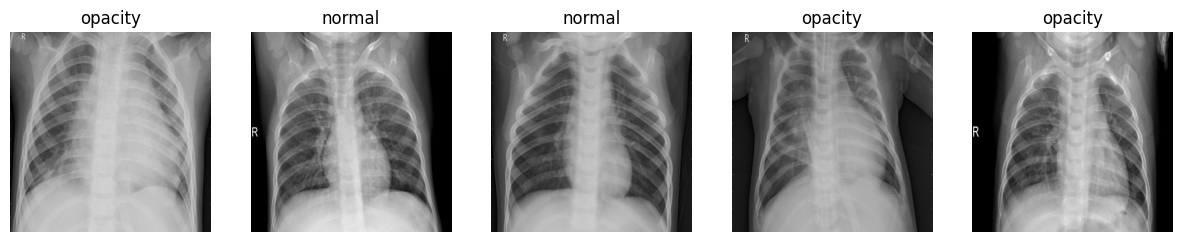

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images in a grid with labels
def show_images(loader, classes, num_images=5):
    # Get a batch of images and labels
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Select num_images randomly from the batch
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    images = images[indices]
    labels = labels[indices]
    
    # Convert images back to numpy array for visualization
    images = images.numpy()
    
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for idx, img in enumerate(images):
        img = np.transpose(img, (1, 2, 0))  # Change shape from (C, H, W) to (H, W, C)
        if img.shape[2] == 1:  # Grayscale image
            img = img.squeeze()
            axes[idx].imshow(img, cmap='gray')
        else:  # RGB image
            axes[idx].imshow(img)
        axes[idx].set_title(classes[labels[idx]])  # Display the label as the title
        axes[idx].axis('off')
    plt.show()

# Assuming you have two classes: 'class0' and 'class1'
classes = train_data.classes  # Get the class names from the dataset

# Display some images from the training loader with labels
show_images(train_loader, classes, num_images=5)


<a id="#preprocessing"></a>
# <p style="background-color: #4D869C; font-family:calibri; color:white; font-size:135%; font-family:Verdana; text-align:center; border-radius:15px 50px; padding: 15px;">Step 3 | Classification Model and Evaluation</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)  # Input shape (500, 500, 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        
        # After convolutions and pooling, calculate the flattened size
        self.fc1 = nn.Linear(64 * 29 * 29, 128)  # This size may need adjustment based on input image size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Conv2D + ReLU
        x = self.pool(x)  # MaxPooling2D
        x = F.relu(self.conv2(x))  # Conv2D + ReLU
        x = self.pool(x)  # MaxPooling2D
        x = F.relu(self.conv3(x))  # Conv2D + ReLU
        x = self.pool(x)  # MaxPooling2D
        x = F.relu(self.conv4(x))  # Conv2D + ReLU
        x = self.pool(x)  # MaxPooling2D
        x = self.flatten(x)  # Flatten
        x = F.relu(self.fc1(x))  # Dense + ReLU
        x = F.relu(self.fc2(x))  # Dense + ReLU
        x = torch.sigmoid(self.fc3(x))  # Dense + Sigmoid
        return x

# Instantiate the model
model = CNNModel()

# Print the model architecture
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=53824, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [11]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model = model.to(device)
    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.view(-1)  # Flatten the outputs for binary classification
                    loss = criterion(outputs, labels.float())

                    # Get predictions (for binary classification, outputs > 0.5 is considered as class 1)
                    preds = outputs > 0.5

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            # Deep copy the model if we get the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return the model and the history of losses and accuracies
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [12]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
train Loss: 0.6606 Acc: 0.6091
val Loss: 0.6740 Acc: 0.6081

Epoch 2/15
----------
train Loss: 0.5451 Acc: 0.7400
val Loss: 0.5275 Acc: 0.7568

Epoch 3/15
----------
train Loss: 0.4154 Acc: 0.8073
val Loss: 0.5237 Acc: 0.7973

Epoch 4/15
----------
train Loss: 0.3132 Acc: 0.8673
val Loss: 0.5019 Acc: 0.8108

Epoch 5/15
----------
train Loss: 0.2350 Acc: 0.9073
val Loss: 0.3697 Acc: 0.8784

Epoch 6/15
----------
train Loss: 0.2179 Acc: 0.9218
val Loss: 0.3948 Acc: 0.8649

Epoch 7/15
----------
train Loss: 0.1841 Acc: 0.9182
val Loss: 0.3865 Acc: 0.9054

Epoch 8/15
----------
train Loss: 0.1684 Acc: 0.9345
val Loss: 0.3209 Acc: 0.9189

Epoch 9/15
----------
train Loss: 0.1381 Acc: 0.9382
val Loss: 0.3418 Acc: 0.9189

Epoch 10/15
----------
train Loss: 0.0917 Acc: 0.9582
val Loss: 0.6589 Acc: 0.8514

Epoch 11/15
----------
train Loss: 0.1179 Acc: 0.9509
val Loss: 0.2623 Acc: 0.9324

Epoch 12/15
----------
train Loss: 0.0638 Acc: 0.9818
val Loss: 0.4173 Acc: 0.9054

E

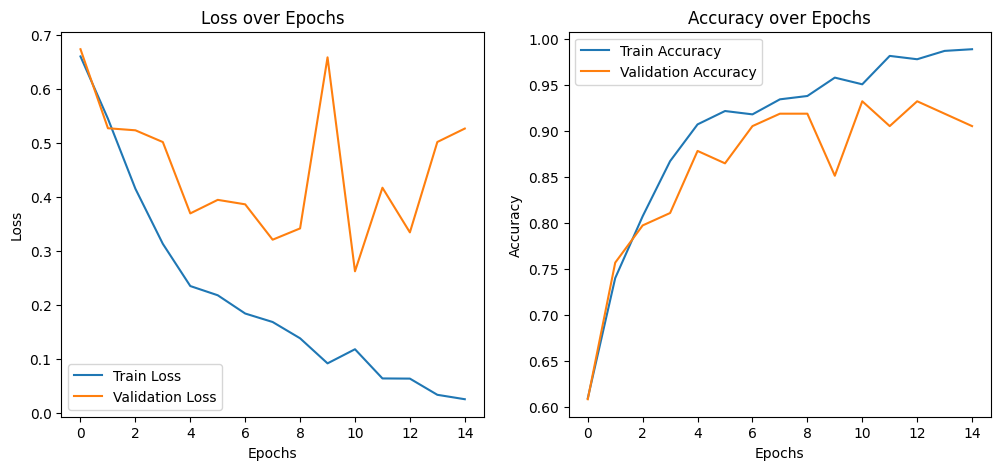

In [13]:
# Plotting loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

<a id=" #conclusions"></a>
# <p style="background-color: #4D869C; font-family:calibri; color:white; font-size:135%; font-family:Verdana; text-align:center; border-radius:15px 50px; padding: 15px;">Step 4 | Save Model & Conclusions</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [14]:
torch.save(trained_model.state_dict(), "xray_cnn.pt")

<div style="border-radius:10px; padding: 15px; background-color: #CDE8E5; font-size:120%; text-align:left; color: #fffff">

<h3 align="left"><font color=#4D869C>Conclusions:</font></h3>
The custom CNN model achieved a best validation accuracy of 93.24%, demonstrating strong performance in distinguishing between "normal" and "opacity" chest X-ray images. This high accuracy indicates that the model effectively learned the distinguishing features between the two classes, making it a reliable tool for binary classification in clinical settings. Further improvements could include fine-tuning hyperparameters, exploring advanced data augmentation techniques, or incorporating additional data to enhance model robustness and generalizability.


In [15]:
# Sajad Hadadi